# Jupyter Notebook: Custom Attention Optimization

Description:
------------
In this notebook, we will:
1. Load a pre-built language model (LLM).
2. Create a copy of the model architecture but replace its attention mechanism with an implementation of Native Sparse Attention from Deepseek.
3. Implement a process to compare the outputs of both models and compute a KL-divergence loss.
4. Optimize the custom model's parameters by minimizing the KL-divergence between the two models’ distributions.
5. Demonstrate how to evaluate and compare both models on sample data.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install datasets
!pip install native-sparse-attention-pytorch

In [ ]:
############## # Code Block 1: Imports & Config ##############
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import GPT2LMHeadModel, GPT2Tokenizer, GPT2Config
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import math
from native_sparse_attention_pytorch import SparseAttention
import time
import psutil
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_NAME = "gpt2"
SEQ_LEN = 128
BATCH_SIZE = 4
NUM_HEADS = 4
COMPRESS_RATIO = 0.25
WINDOW_SIZE = 64
NUM_EPOCHS = 50

# Native sparse attention configuration
SPARSE_CONFIG = {
    "dim": None,  # Will be set in the model
    "dim_head": 64,  # Dimension per head
    "heads": NUM_HEADS,
    "sliding_window_size": 2,  # Local attention window
    "compress_block_size": 4,  # Size of blocks to compress
    "selection_block_size": 4,  # Size of blocks to select from
    "num_selected_blocks": 2,  # Number of blocks to select
}

In [ ]:
############## # Code Block 2: Sparse Attention Components ##############
class CompressedGlobalAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, compress_ratio):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.compress_ratio = compress_ratio

        self.Wq = nn.Linear(embed_dim, embed_dim)
        self.Wk = nn.Linear(embed_dim, embed_dim)
        self.Wv = nn.Linear(embed_dim, embed_dim)
        self.compression = nn.Linear(embed_dim, 1)
        self.expansion = nn.Linear(embed_dim, embed_dim)

    def forward(self, x, attention_mask=None):
        B, T, D = x.shape
        keep_num = max(1, int(T * self.compress_ratio))

        # Token compression
        importance = self.compression(x).squeeze(-1)
        _, keep_idx = torch.topk(importance, k=keep_num, dim=-1)
        x_compressed = torch.gather(x, 1, keep_idx.unsqueeze(-1).expand(-1, -1, D))

        # Projections
        Q = self.Wq(x).view(B, T, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        K = (
            self.Wk(x_compressed)
            .view(B, keep_num, self.num_heads, self.head_dim)
            .permute(0, 2, 1, 3)
        )
        V = (
            self.Wv(x_compressed)
            .view(B, keep_num, self.num_heads, self.head_dim)
            .permute(0, 2, 1, 3)
        )

        # Attention
        attn_scores = torch.matmul(Q, K.transpose(-1, -2)) / math.sqrt(self.head_dim)

        # Masking
        if attention_mask is not None:
            compressed_mask = torch.gather(attention_mask, 1, keep_idx)
            attn_scores = attn_scores.masked_fill(
                compressed_mask.unsqueeze(1).unsqueeze(2) == 0, -1e10
            )

        attn_weights = F.softmax(attn_scores, dim=-1)
        output = torch.matmul(attn_weights, V)
        output = output.permute(0, 2, 1, 3).contiguous().view(B, T, D)

        output = self.expansion(output)  # Ensure output has correct embedding dimension
        output = output[:, : x.size(1), :]

        return output


class LocalWindowAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, window_size):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.window_size = window_size

        self.Wq = nn.Linear(embed_dim, embed_dim)
        self.Wk = nn.Linear(embed_dim, embed_dim)
        self.Wv = nn.Linear(embed_dim, embed_dim)

    def create_window_mask(self, seq_len, device):
        mask = torch.zeros(seq_len, seq_len, device=device)
        for i in range(seq_len):
            start = max(0, i - self.window_size // 2)
            end = min(seq_len, i + self.window_size // 2 + 1)
            mask[i, start:end] = 1
        return mask.unsqueeze(0).unsqueeze(1)

    def forward(self, x, attention_mask=None):
        B, T, D = x.shape
        window_mask = self.create_window_mask(T, x.device)

        Q = self.Wq(x).view(B, T, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        K = self.Wk(x).view(B, T, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        V = self.Wv(x).view(B, T, self.num_heads, self.head_dim).permute(0, 2, 1, 3)

        attn_scores = torch.matmul(Q, K.transpose(-1, -2)) / math.sqrt(self.head_dim)
        attn_scores = attn_scores.masked_fill(window_mask == 0, -1e10)

        if attention_mask is not None:
            attn_scores = attn_scores.masked_fill(
                attention_mask.unsqueeze(1).unsqueeze(2) == 0, -1e10
            )

        attn_weights = F.softmax(attn_scores, dim=-1)
        output = torch.matmul(attn_weights, V)
        return output.permute(0, 2, 1, 3).contiguous().view(B, T, D)


class HierarchicalSparseAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, window_size, compress_ratio):
        super().__init__()
        self.num_heads = num_heads  # 🔹 Store num_heads
        self.local_attn = LocalWindowAttention(embed_dim, num_heads, window_size)
        self.global_attn = CompressedGlobalAttention(
            embed_dim, num_heads, compress_ratio
        )
        self.gate = nn.Sequential(
            nn.Linear(
                embed_dim, num_heads * 2
            ),  # Ensure output is [batch, seq_len, num_heads * 2]
            nn.Softmax(dim=-1),
        )
        self.out_proj = nn.Linear(embed_dim, embed_dim)

    def forward(self, x, attention_mask=None):
        # Get outputs from local and global attention modules.
        local_out = self.local_attn(x, attention_mask)  # Expected shape: (B, T, D)
        global_out = self.global_attn(x, attention_mask)  # Expected shape: (B, T, D)

        B, T, D = x.size()
        head_dim = D // self.num_heads  # Ensure D is divisible by num_heads

        # Compute gating weights.
        # self.gate should output a tensor of shape (B, T, num_heads*2)
        gate_out = self.gate(x)  # Shape: (B, T, num_heads*2)
        # Reshape to (B, T, num_heads, 2) where last dim holds [local_gate, global_gate]
        gates = gate_out.view(B, T, self.num_heads, 2)
        # Unbind the last dimension into two tensors
        local_gate = gates[..., 0]  # Shape: (B, T, num_heads)
        global_gate = gates[..., 1]  # Shape: (B, T, num_heads)

        # Reshape attention outputs to split heads: (B, T, num_heads, head_dim)
        local_out_heads = local_out.view(B, T, self.num_heads, head_dim)
        global_out_heads = global_out.view(B, T, self.num_heads, head_dim)

        # Ensure the gate tensors have an extra dimension for broadcasting: (B, T, num_heads, 1)
        local_gate = local_gate.unsqueeze(-1)
        global_gate = global_gate.unsqueeze(-1)

        # Element-wise multiply each head output by its corresponding gate weight
        combined = local_out_heads * local_gate + global_out_heads * global_gate
        # Reshape back to (B, T, D)
        combined = combined.view(B, T, D)
        return self.out_proj(combined)

In [ ]:
############## # Code Block 3: Custom GPT-2 Model ##############
class SparseGPT2(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.wte = nn.Embedding(config.vocab_size, config.hidden_size)
        self.wpe = nn.Embedding(config.max_position_embeddings, config.hidden_size)
        self.drop = nn.Dropout(config.embd_pdrop)

        # Create native sparse attention layer with correct parameters
        sparse_config = SPARSE_CONFIG.copy()
        sparse_config["dim"] = config.hidden_size
        sparse_config["compress_block_sliding_stride"] = 2
        self.sparse_attn = SparseAttention(**sparse_config)

        self.h = nn.ModuleList(
            [
                nn.ModuleDict(
                    {
                        "attn": self.sparse_attn,
                        "ln_1": nn.LayerNorm(config.hidden_size),
                        "mlp": nn.Sequential(
                            nn.Linear(config.hidden_size, 4 * config.hidden_size),
                            nn.GELU(),
                            nn.Linear(4 * config.hidden_size, config.hidden_size),
                        ),
                        "ln_2": nn.LayerNorm(config.hidden_size),
                    }
                )
                for _ in range(config.num_hidden_layers)
            ]
        )
        self.ln_f = nn.LayerNorm(config.hidden_size)
        self.lm_head = nn.Linear(config.hidden_size, config.vocab_size)

    def forward(self, input_ids, attention_mask=None):
        B, T = input_ids.size()
        pos_ids = torch.arange(T, device=DEVICE).unsqueeze(0)

        x = self.drop(self.wte(input_ids) + self.wpe(pos_ids))

        attn_out = torch.zeros_like(x)

        for block in self.h:
            # Apply layer norm before attention
            normed_x = block["ln_1"](x)
            attention_result = block["attn"](normed_x)

            # Apply sparse attention and handle tuple output
            if attention_result is not None:
                attn_out = attention_result

            # Apply mask after attention if provided
            if attention_mask is not None:
                attn_out = attn_out * attention_mask.unsqueeze(-1)

            x = x + attn_out
            x = x + block["mlp"](block["ln_2"](x))

        x = self.ln_f(x)
        logits = self.lm_head(x)
        return logits  # Return only the logits, not a tuple

In [ ]:
############## # Code Block 4: Training Setup ##############
tokenizer = GPT2Tokenizer.from_pretrained(MODEL_NAME)
tokenizer.pad_token = tokenizer.eos_token

# Reference model
ref_model = GPT2LMHeadModel.from_pretrained(MODEL_NAME).to(DEVICE)
ref_model.eval()

# Custom model with native sparse attention
cust_config = GPT2Config.from_pretrained(MODEL_NAME)
cust_model = SparseGPT2(cust_config).to(DEVICE)

# Initialize with pretrained weights
pretrained_state_dict = ref_model.state_dict()
cust_model.load_state_dict(pretrained_state_dict, strict=False)

# Use a lower learning rate for fine-tuning
optimizer = torch.optim.AdamW(cust_model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

In [ ]:
############## # Code Block 5: Training Loop ##############
class UsageTracker:
    def __init__(self):
        self.start_time = None
        self.start_cpu_time = None
        self.train_stats = {
            "epoch": [], "step": [],
            "wall_time_s": [], "cpu_time_s": [],
            "cpu_mem_mb": [], "gpu_alloc_mb": [], "gpu_reserved_mb": []
        }
        self.infer_stats = {
            "max_token_length": [],
            "wall_time_s": [], "cpu_time_s": [],
            "cpu_mem_mb": [], "gpu_alloc_mb": [], "gpu_reserved_mb": []
        }

    def start_tracking(self):
        self.start_time = time.time()
        self.start_cpu_time = time.process_time()

    def stop_tracking(self, is_training, epoch=None, step=None, max_token_length=None):
        if self.start_time is None or self.start_cpu_time is None:
            raise ValueError("Tracking not started. Call start_tracking() first.")

        end_time = time.time()
        end_cpu_time = time.process_time()

        proc = psutil.Process(os.getpid())
        cpu_mem = proc.memory_info().rss / (1024**2)
        if torch.cuda.is_available():
            gpu_alloc    = torch.cuda.memory_allocated(DEVICE) / (1024**2)
            gpu_reserved = torch.cuda.memory_reserved(DEVICE) / (1024**2)
        else:
            gpu_alloc = gpu_reserved = 0.0

        obj = self.train_stats if is_training else self.infer_stats
        obj["wall_time_s"].append(end_time - self.start_time)
        obj["cpu_time_s"].append(end_cpu_time - self.start_cpu_time)
        obj["cpu_mem_mb"].append(cpu_mem)
        obj["gpu_alloc_mb"].append(gpu_alloc)
        obj["gpu_reserved_mb"].append(gpu_reserved)
        if is_training:
            obj["epoch"].append(epoch + 1)
            obj["step"].append(step + 1)
        else:
            obj["max_token_length"].append(max_token_length)

        self.start_time = None
        self.start_cpu_time = None

    def plot(self):
        df_train = pd.DataFrame(self.train_stats)
        df_inf   = pd.DataFrame(self.infer_stats)

        # --- Training plots (line plots vs. step) ---
        for metric in ["wall_time_s", "cpu_time_s", "cpu_mem_mb", "gpu_alloc_mb", "gpu_reserved_mb"]:
            plt.figure(figsize=(8, 4))
            plt.plot(df_train["step"], df_train[metric])
            plt.xlabel("Training Step")
            plt.ylabel(metric.replace("_", " ").title())
            plt.title(f"{metric.replace('_', ' ').title()} During Training")
            plt.show()

        prompt_lengths = self.infer_stats["max_token_length"]

        # --- Inference plots (bar plots vs. token length) ---
        for metric in ["wall_time_s", "cpu_time_s", "cpu_mem_mb", "gpu_alloc_mb", "gpu_reserved_mb"]:
            plt.figure(figsize=(8, 4))
            plt.scatter(prompt_lengths, self.infer_stats[metric])
            plt.xlabel("Prompt Token Length")
            plt.ylabel(metric.replace("_", " ").title())
            plt.title(f"{metric.replace('_', ' ').title()} vs. Prompt Length")
            plt.show()

def kl_divergence_loss(logits_custom, logits_ref, mask, temperature):
    # 1) soften both distributions by T
    logp_c = F.log_softmax(logits_custom / temperature, dim=-1)
    p_r   = F.softmax(   logits_ref.detach() / temperature, dim=-1)

    # 2) per‑token KL
    kl = (p_r * (p_r.log() - logp_c)).sum(-1)  # (B, L)

    # 3) average over real tokens and re‑scale by T^2
    return (kl * mask).sum() / mask.sum() * (temperature * temperature)

def train_step(batch, epoch, step):
    tracker.start_tracking()

    inputs = batch.to(DEVICE)
    attention_mask = (inputs != tokenizer.pad_token_id).float()

    with torch.no_grad():
        ref_outputs = ref_model(inputs, attention_mask=attention_mask)
        if isinstance(ref_outputs, tuple):
            ref_logits = ref_outputs[0]
        else:
            ref_logits = ref_outputs.logits  # Extract logits from the output object

    cust_outputs = cust_model(inputs, attention_mask=attention_mask)
    if isinstance(cust_outputs, tuple):
        cust_logits = cust_outputs[0]
    else:
        cust_logits = cust_outputs

    # Use KL divergence loss with temperature
    temperature = 0.7
    loss = F.kl_div(
        F.log_softmax(cust_logits / temperature, dim=-1),
        F.softmax(ref_logits / temperature, dim=-1).detach(),
        reduction="sum"
    ) * (temperature**2)

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(cust_model.parameters(), 1.0)
    optimizer.step()

    tracker.stop_tracking(is_training=True, epoch=epoch, step=step)

    return loss.item()


def train_epoch(loader, epoch):
    cust_model.train()
    total_loss = 0
    loss_vals = []
    for i, batch in tqdm(enumerate(loader), desc="Training"):
        loss = train_step(batch, epoch, i)
        total_loss += loss
        loss_vals.append(loss)
    return total_loss / len(loader), loss_vals

In [ ]:
############## # Code Block 6: Generation & Evaluation ##############
def generate(model, tokenizer, prompt, max_length=50, temperature=0.7, top_k=50, device="cuda" if torch.cuda.is_available() else "cpu"):
    input_ids = tokenizer.encode(prompt, return_tensors="pt", add_special_tokens=False).to(device)
    input_ids = input_ids[:1]  # Ensure we only have one batch dimension

    model.to(device)
    model.eval()

    for _ in range(max_length):
        with torch.no_grad():
            outputs = model(input_ids)
            logits = outputs.logits if hasattr(outputs, "logits") else outputs

            # Get logits for the last token
            if logits.dim() == 3:  # Standard shape [batch, seq, vocab]
                next_token_logits = logits[:, -1, :] / temperature
            elif logits.dim() == 2:  # If somehow we got [batch*seq, vocab]
                # We only care about the last token's logits
                next_token_logits = logits[-1:, :] / temperature
            else:
                raise ValueError(f"Unexpected logits shape: {logits.shape}")

            # Apply top-k filtering
            top_k_logits, top_k_indices = torch.topk(next_token_logits, k=top_k, dim=-1)

            # Convert to probabilities
            probs = F.softmax(top_k_logits, dim=-1)

            # Sample next token index from top-k logits
            next_token_idx = torch.multinomial(probs, num_samples=1)
            next_token = top_k_indices.gather(1, next_token_idx)

            # Ensure next_token has shape [1, 1]
            next_token = next_token[-1:, :]  # Take only the last row if needed

            # Concatenate to input_ids
            input_ids = torch.cat([input_ids, next_token], dim=-1)

    return tokenizer.decode(input_ids[0], skip_special_tokens=True)

In [ ]:
############## # Code Block 7: Dataset Preparation ##############
from datasets import load_dataset


class WikiDataset(Dataset):
    def __init__(self, texts, tokenizer, seq_len):
        self.samples = []
        for text in texts:
            # Tokenize each text separately, without adding special tokens
            token_ids = tokenizer.encode(text, add_special_tokens=False)
            # Split token_ids into chunks of length seq_len
            for i in range(0, len(token_ids), seq_len):
                chunk = token_ids[i : i + seq_len]
                # Only add full chunks to avoid very short sequences
                if len(chunk) == seq_len:
                    self.samples.append(torch.tensor(chunk))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]


# Load WikiText data
dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split="train[:100%]")
texts = dataset["text"]
wiki_dataset = WikiDataset(texts, tokenizer, SEQ_LEN)

# Create a DataLoader for training
train_loader = DataLoader(wiki_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
############## # Code Block 8: Training Execution ##############
tracker = UsageTracker()

CHECKPOINT_DIR = '/content/drive/MyDrive/attention_optimization/model_checkpoints'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

cust_model.train()

for epoch in range(0, NUM_EPOCHS):

    avg_loss, loss_vals = train_epoch(train_loader, epoch)
    scheduler.step()

    print(f"Epoch {epoch+1}/{NUM_EPOCHS} - Average Loss: {avg_loss:.4f}")

    # Generate sample text after each epoch
    if (epoch + 1) % 2 == 0:  # Generate every 2 epochs
        print("\nGenerating sample text:")
        prompt = "Artificial intelligence"
        print("Reference:", generate(ref_model, tokenizer, prompt, temperature=0.7, top_k=50))
        print("Custom:", generate(cust_model, tokenizer, prompt, temperature=0.7, top_k=50))
        print("\n")

    # checkpoint model vars
    if (epoch + 1) % 10 == 0:
        checkpoint = {
            'epoch': epoch + 1, # next epoch to start from
            'model_state_dict': cust_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss_vals': loss_vals,
        }
        torch.save(checkpoint, os.path.join(CHECKPOINT_DIR, f'ckpt_epoch_{epoch+1}.pth'))
        print(f"Saved checkpoint for epoch {epoch+1}")

# Final generation comparison
prompt = "Artificial intelligence"
print("\nFinal generation comparison:")
print("Reference:", generate(ref_model, tokenizer, prompt, temperature=0.7, top_k=50))
print("Custom:", generate(cust_model, tokenizer, prompt, temperature=0.7, top_k=50))


Training: 2571it [08:56,  4.79it/s]


Epoch 1/50 - Average Loss: 713.7411


Training: 2571it [08:56,  4.80it/s]


Epoch 2/50 - Average Loss: 473.6092

Generating sample text:
Reference: Artificial intelligence has become something of a mainstream tool for the job of measuring the progress of technology. For example, the US government has been exploring the possibility of developing a computer vision system called the "smart grid," which will be able to recognize the locations of people
Custom: Artificial intelligence-VQ, @-@-@ was in @-@ at @. and @-@-@ who are all to from-@ ) ( . , at @- @-@ and @-@s to- @-@




Training: 2571it [08:46,  4.88it/s]


Epoch 3/50 - Average Loss: 386.2424


Training: 2571it [08:46,  4.89it/s]


Epoch 4/50 - Average Loss: 330.4077

Generating sample text:
Reference: Artificial intelligence (AI) refers to the ability to combine two or more different types of information in a way that makes sense and that is not immediately intuitive. For example, if you believe that a person's face or hair color is a natural, you can infer
Custom: Artificial intelligence models and a specific one-style, so much more affordable- and other engines to create new technologies caretaker area, the technology market was based in all the industry were not yet built.







 and the AAS




Training: 2571it [09:02,  4.74it/s]


Epoch 5/50 - Average Loss: 290.2517


Training: 2571it [08:56,  4.79it/s]


Epoch 6/50 - Average Loss: 259.3570

Generating sample text:
Reference: Artificial intelligence is now being used in a wide variety of industries, from food processing to manufacturing, from health care to transportation—and we're all using it to better understand and understand everything we're doing.

What's your view on artificial intelligence getting into
Custom: Artificial intelligence-JA 2.

. This is a very large-order quality that allows for the information collected data from the same as and that it represents a one a new one . The argument is that it is used to be the most positive, and




Training: 2571it [08:43,  4.91it/s]


Epoch 7/50 - Average Loss: 234.0534


Training: 2571it [08:47,  4.87it/s]


Epoch 8/50 - Average Loss: 212.9722

Generating sample text:
Reference: Artificial intelligence is not only possible but useful. Artificial intelligence is the tool that has been used by many nations in the world for many years to help solve complex problems. It's also the way that our entire system is designed. And how it works.


Custom: Artificial intelligence is a standard of social cognition are often used to, but with respect-values- or without the term itself. for the sake differences in the social framework of the term "conianism for the right to the right is the basis for by the




Training: 2571it [08:44,  4.90it/s]


Epoch 9/50 - Average Loss: 195.1837


Training: 2571it [08:45,  4.89it/s]


Epoch 10/50 - Average Loss: 179.6458

Generating sample text:
Reference: Artificial intelligence has shown promise as a tool for improving human health, but it has always been a problem for the military, which is often concerned about a person's risk of slipping into a coma.

The human brain is one of the most important parts of
Custom: Artificial intelligence-s
C 2-G-@-@-@-@ .-@@-@@@@@@-@@@@@ @@ @-@@@@@@@@@@@@@ @


Saved checkpoint for epoch 10


Training: 2571it [08:45,  4.89it/s]


Epoch 11/50 - Average Loss: 166.2986


Training: 2571it [08:43,  4.91it/s]


Epoch 12/50 - Average Loss: 154.5894

Generating sample text:
Reference: Artificial intelligence, or AI, has been around for a long time. AI is a term that's used to describe technology that can be applied to any kind of task, even if it's only for its own sake. It's a very different field than the
Custom: Artificial intelligence is also known as the "super " – or " (e • " ). " " , the " " nnionia " " , or " for " " , " " ( " " , " " " , " , " " "




Training: 2571it [08:45,  4.89it/s]


Epoch 13/50 - Average Loss: 144.5412


Training: 2571it [08:44,  4.90it/s]


Epoch 14/50 - Average Loss: 135.5315

Generating sample text:
Reference: Artificial intelligence is a technology that allows people to use the internet to communicate. It has the potential to revolutionize our lives by giving us the capacity to make decisions about our actions, actions that we can control.

I will never, ever write a book
Custom: Artificial intelligence is that "the " is " to " and " is " not in " not necessary " " [i " ) " ). " ; and " " and " " " " in " " " " " , " " " and " " "




Training: 2571it [08:51,  4.84it/s]


Epoch 15/50 - Average Loss: 127.3210


Training: 2571it [08:49,  4.86it/s]


Epoch 16/50 - Average Loss: 120.2580

Generating sample text:
Reference: Artificial intelligence is a complex topic. In particular, the subject's "intelligence" (i.e., a particular set of problems) is often not sufficiently complex to allow for reasoning about its complexity. For example, there is no set of problems where the "
Custom: Artificial intelligence has been the only system to maintain that its composition be the original.8, which is a product created by the original series creators and is an important part of the original game, and the way back-style is or the one-game site which




Training: 2571it [08:51,  4.83it/s]


Epoch 17/50 - Average Loss: 113.5728


Training: 2571it [08:46,  4.89it/s]


Epoch 18/50 - Average Loss: 107.6227

Generating sample text:
Reference: Artificial intelligence can help you learn more about the world around you, and you might just be able to create new business opportunities.

How can I make more money with AI?

It's simple:

To learn more about AI and how to
Custom: Artificial intelligence is still a form of administration.S. — but it is generally accepted for sale and on the subjects or health.

D-M is not only created in a way that non- @ n-cazazuha�anthi




Training: 2571it [08:47,  4.87it/s]


Epoch 19/50 - Average Loss: 102.0975


Training: 2571it [08:45,  4.89it/s]


Epoch 20/50 - Average Loss: 96.9515

Generating sample text:
Reference: Artificial intelligence is about to become an all-purpose machine for the Internet of Things, and now it's set to become an important tool for building and managing smart cities.

A prototype of the SaaS market

The new company, Saa
Custom: Artificial intelligence will be in the following year of the new year 2018, but the number of seats required the minimum number one for such a state or not required to be taken by the same same in the number three.
A is required for the purposes was is


Saved checkpoint for epoch 20


Training: 2571it [08:47,  4.88it/s]


Epoch 21/50 - Average Loss: 92.2124


Training: 2571it [08:49,  4.85it/s]


Epoch 22/50 - Average Loss: 87.8756

Generating sample text:
Reference: Artificial intelligence, or AI, is a discipline that allows humans to solve problems and solve problems. As such, it is not only possible for human beings to solve complex problems, but it is also possible for robots to do just about anything. It has been theor
Custom: Artificial intelligence. to the point where the user can find the need for the next move. as the next day after it, our understanding, they will need to have received by the owner or of the National Security Council, for the last remaining three of the four




Training: 2571it [08:47,  4.87it/s]


Epoch 23/50 - Average Loss: 83.6362


Training: 2571it [08:48,  4.86it/s]


Epoch 24/50 - Average Loss: 79.6675

Generating sample text:
Reference: Artificial intelligence will also be a great part of the future, but there are plenty of ways that it could be used in the next 20 years, especially if we can learn to work with information from other sources.

"It may be an incredible future for
Custom: Artificial intelligence was built on the site of an old military, but was destroyed in the same way that it the most dangerous method of life time is the general of the general," and the ability to to do with the general populace .
 The General Department was responsible




Training: 2571it [08:49,  4.86it/s]


Epoch 25/50 - Average Loss: 75.9868


Training: 2571it [08:41,  4.93it/s]


Epoch 26/50 - Average Loss: 72.4288

Generating sample text:
Reference: Artificial intelligence systems are becoming increasingly sophisticated, and in this case they're far more complex than we knew. This is why we need to keep an eye on our new intelligence.

Now, we have a lot of data coming in, and a lot of
Custom: Artificial intelligence has been well-owned for any other agency. We will get something like a business company called a "big system " package to fund a business venture.










" (VMA ) ) ) ).




Training: 2571it [08:45,  4.89it/s]


Epoch 27/50 - Average Loss: 69.0307


Training: 2571it [08:45,  4.89it/s]


Epoch 28/50 - Average Loss: 65.8065

Generating sample text:
Reference: Artificial intelligence is also on the rise, and it's becoming more and more popular. This has led to the creation of an AI based on artificial intelligence.

Some experts think AI could be the future of finance. The US government has recently announced that it
Custom: Artificial intelligence.

The is one of those that the current policy might be "unzka-L (ELER ) ) is a very important project that has been on long line and it seems to be the case of two broad-valueater




Training: 2571it [08:41,  4.93it/s]


Epoch 29/50 - Average Loss: 62.7706


Training: 2571it [08:48,  4.87it/s]


Epoch 30/50 - Average Loss: 59.8619

Generating sample text:
Reference: Artificial intelligence is a system of processing and evaluation that is able to work in a variety of areas from the natural world to the political economy to the sciences. The goal of AI is to have the ability to solve human-produced problems in a way that does not
Custom: Artificial intelligence. The project is based on the knowledge that it means means that you are using for our computer game.






A 2 is an unconnected, which is a set of analogue.

A 2 is also able to


Saved checkpoint for epoch 30


Training: 2571it [08:54,  4.81it/s]


Epoch 31/50 - Average Loss: 57.0613


Training: 2571it [08:47,  4.87it/s]


Epoch 32/50 - Average Loss: 54.4696

Generating sample text:
Reference: Artificial intelligence is increasingly used to produce highly complex, highly complex machines. The problem is that it would be impossible to know what such machines are designed to do. In the 1960s, a group of researchers developed a computer program that could model the behavior of humans
Custom: Artificial intelligence is not a source (orazun, the standard method, so for a degree degree or a degree degree degree degree degree degree is a discipline term, and A, is an adjunct and is not compatible.


E is SAC,




Training: 2571it [08:53,  4.82it/s]


Epoch 33/50 - Average Loss: 51.9964


Training: 2571it [08:55,  4.81it/s]


Epoch 34/50 - Average Loss: 49.6875

Generating sample text:
Reference: Artificial intelligence, or AI, is a group of ideas that can be applied to a wide variety of problems. A big part of the challenge for AI researchers is to solve problems because they are so frequently ignored — and that makes the problem more complex than it should
Custom: Artificial intelligence is that the best way to get a program that he had just spent too much to to build up with the money he had said would be "more " about the world. The problem was that there were any other team in the universe.
"




Training: 2571it [08:52,  4.83it/s]


Epoch 35/50 - Average Loss: 47.5171


Training: 2571it [08:47,  4.87it/s]


Epoch 36/50 - Average Loss: 45.4884

Generating sample text:
Reference: Artificial intelligence (AI) is currently very much in its infancy. It is currently being developed to help AI operators understand and perform complex tasks on human beings. But the future is in the data. AI is the future.

"Most people have not heard
Custom: Artificial intelligence:





IW2 ) .

EO: . (Source ) , page =ラ all original sources for the film, or, $ or $4.






1 ) in its




Training: 2571it [08:48,  4.86it/s]


Epoch 37/50 - Average Loss: 43.6427


Training: 2571it [08:49,  4.86it/s]


Epoch 38/50 - Average Loss: 41.9639

Generating sample text:
Reference: Artificial intelligence (AI) is also being used as a method for creating virtual reality. This is a device that "blasts" an object, which is then projected onto a screen or screen image.

The company says it's working on a prototype that
Custom: Artificial intelligence service to meet up space aircraft. These aircraft and that they could fly to a destination.




 , 4/ groups were at the same time as the other companies were in fact the first plane in the United States to be able to




Training: 2571it [08:48,  4.87it/s]


Epoch 39/50 - Average Loss: 40.4302


Training: 2571it [08:47,  4.87it/s]


Epoch 40/50 - Average Loss: 39.0827

Generating sample text:
Reference: Artificial intelligence is also a new field of research that is not yet quite as well supported by existing scientific publications and theoretical models. The goal of this study was to determine whether computational processes that are associated with the development of artificial intelligence could be used to address some of
Custom: Artificial intelligence. The first two forms of the process requires multiple paths, which are the initial designs of three elements. and the order are mutually and well written in the first place place.

1: and the fifth of the two are included is a total


Saved checkpoint for epoch 40


Training: 2571it [08:48,  4.87it/s]


Epoch 41/50 - Average Loss: 37.9204


Training: 2571it [08:45,  4.89it/s]


Epoch 42/50 - Average Loss: 36.9032

Generating sample text:
Reference: Artificial intelligence technology, but at the same time, it makes sense to do so in a way that can allow for smart contracts, and the possibility of smart contracts being used to secure an individual's financial data, or to set up a business for a customer that
Custom: Artificial intelligence






S.






E/ "The " "
QOOM-" " / " . Please.





T/ " " and " video video game "




Training: 2571it [08:46,  4.88it/s]


Epoch 43/50 - Average Loss: 36.0380


Training: 2571it [08:47,  4.87it/s]


Epoch 44/50 - Average Loss: 35.3165

Generating sample text:
Reference: Artificial intelligence is the new frontier for robotics, and it's starting to look like it's going to be a big part of the future.

A robot will be able to do more than just read and write, it will also learn about people's lives
Custom: Artificial intelligence. It can be useful for this person for your own actions. However, the game's-X and the game, and what makes you all the more time he is the one that people can and can only do have come out of the screen."




Training: 2571it [08:47,  4.88it/s]


Epoch 45/50 - Average Loss: 34.7358


Training: 2571it [08:44,  4.91it/s]


Epoch 46/50 - Average Loss: 34.2896

Generating sample text:
Reference: Artificial intelligence could be used to improve the health of those who suffer from high doses of chemotherapy, according to research published in the journal Science today.

The study, led by Dr. Kari R. D. Yee, a professor of medicine at
Custom: Artificial intelligence is the same, which can be thought of. a person's or group.
The and all the known as the "bethoven-S , part of which was originally known as the " " (from " ( " the group of members




Training: 2571it [08:46,  4.88it/s]


Epoch 47/50 - Average Loss: 33.9443


Training: 2571it [08:42,  4.92it/s]


Epoch 48/50 - Average Loss: 33.6892

Generating sample text:
Reference: Artificial intelligence is based on our ability to learn faster, to learn more efficiently, to better understand the world and to learn more efficiently than we could ever have expected.

Some people who are experts in this field have been saying about AI for years, and
Custom: Artificial intelligence service and the research project of the Tiberk and the M.A and the European Union Bank for the Development's and the OJJICE, which is the largest publicly available source code for analysis of the site's and other properties of




Training: 2571it [08:47,  4.87it/s]


Epoch 49/50 - Average Loss: 33.5379


Training: 2571it [08:44,  4.90it/s]


Epoch 50/50 - Average Loss: 33.4617

Generating sample text:
Reference: Artificial intelligence is only part of the story. The other part is that we have a problem that nobody is interested in solving; it's a problem that we need to solve. And then, by the way, there is a big difference between the two kinds of
Custom: Artificial intelligence and software software tools. on a computer hardware. The same as the one-endronomycinidic (S 2 ),) "L"o , the popular Japanese scientist IraZenalomos , a bonychch-1


Saved checkpoint for epoch 50

Final generation comparison:
Reference: Artificial intelligence is a big leap forward for artificial intelligence and is likely to be a big step forward for computer science in the near future," said Robert G. Pomeroy, a professor of computer science and computing at Virginia Tech. "The question is, can
Custom: Artificial intelligence is necessary, which is a non-param form. A simple derivaric acid, including (e . N. p. arlphobicatoseosel in a group of 

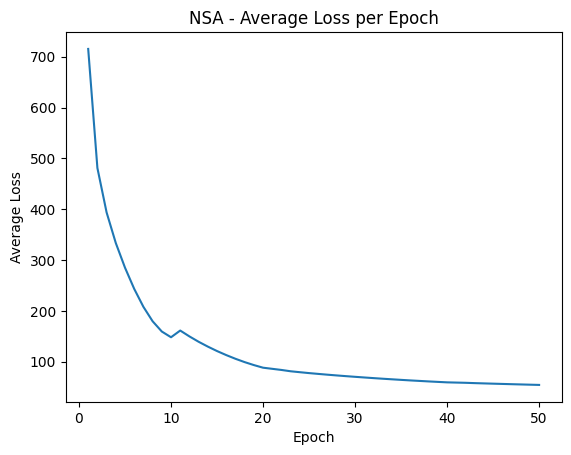

In [ ]:
plt.plot(range(1, NUM_EPOCHS + 1), loss_vals)
plt.title('NSA - Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

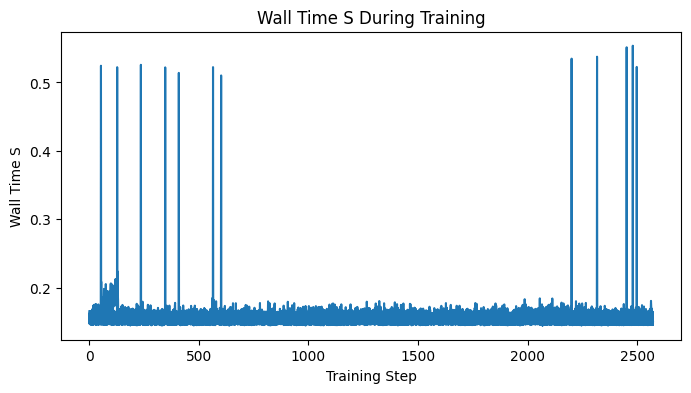

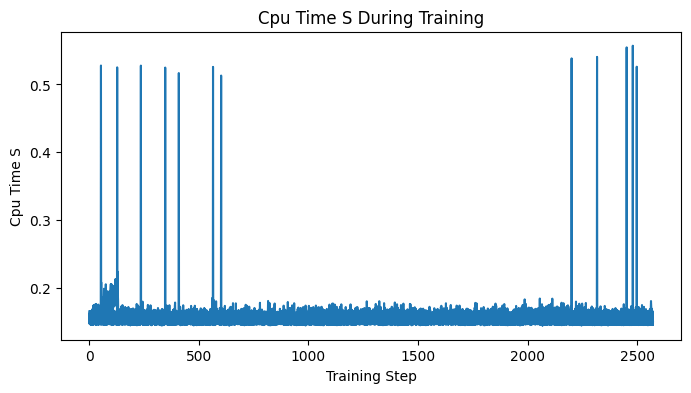

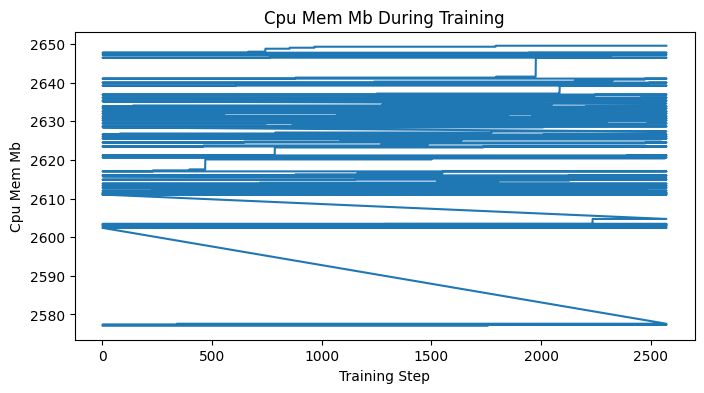

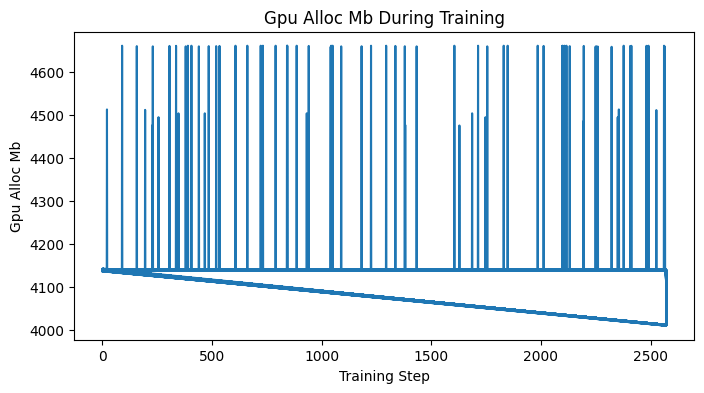

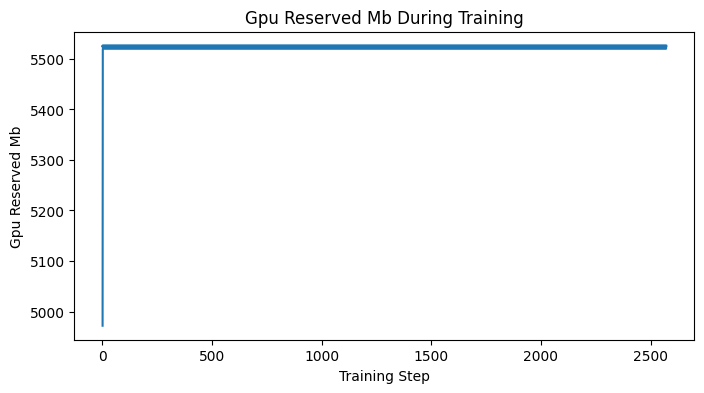

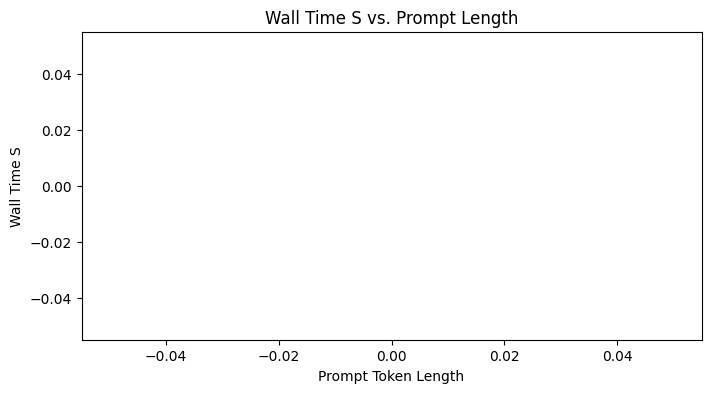

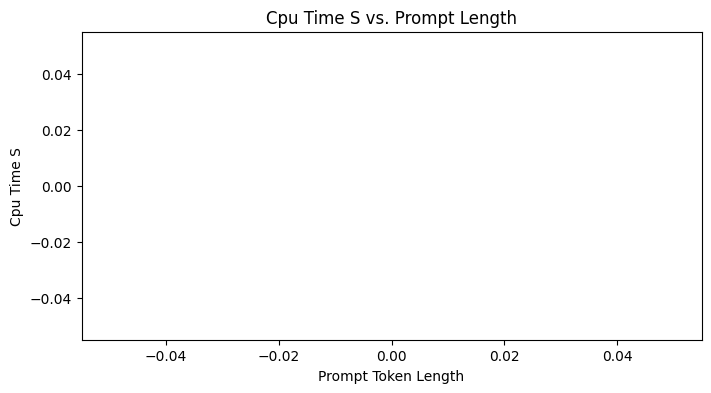

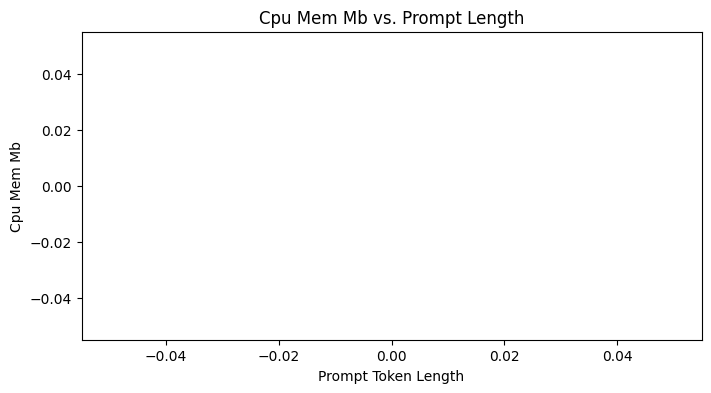

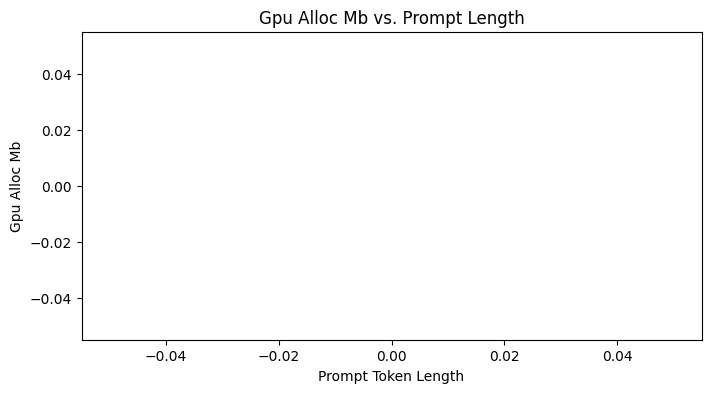

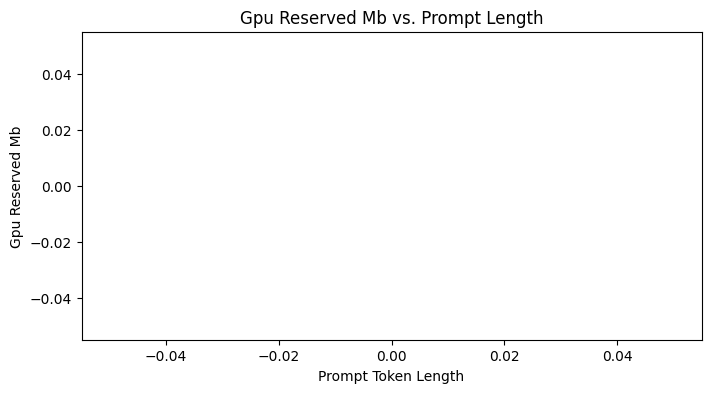

In [ ]:
tracker.plot()

# Conclusion

We have demonstrated:
1.   Loading a reference GPT-2 model from Hugging Face.
2.   Creating a custom GPT-2-like model with an NSA attention mechanism.
3. Setting up a dataset and training loop that optimizes the custom model to match the reference distribution via KL-divergence.
4. Showed a simple comparison of generated text from both models.

This notebook is purely for demonstration and educational purposes, and many improvements could be made:
- More elaborate data loading
- Proper scheduling, regularization
- Additional GPT-2 intricacies (like caching attention states, etc.)
- More advanced generation strategies (beam search, top-k, top-p, etc.)

But this entire workflow shows how one could begin to experiment with custom attention
mechanisms and align them to a known distribution via KL divergence.